# **EPC. EDA. Segundo proyecto**

En este apartado se lleva a cabo el análisis exploratorio de los datos

## 0. Preparativos

Importar la base que resultó del ETL y las librerías necesarias para este apartado

In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import seaborn as sns
import numpy as np
import funciones_propias as fp
from sklearn.preprocessing import MinMaxScaler
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from matplotlib.lines import Line2D

In [2]:
fp.limitar()
ruta_archivo_parquet = 'bases/siniestros.parquet'
df_siniestros = pd.read_parquet(ruta_archivo_parquet)

Obtenemos la información general de la base

In [3]:
df_siniestros.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 704 entries, 0 to 703
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Id                        704 non-null    object        
 1   N_Victimas                704 non-null    int64         
 2   Fecha_Siniestro           704 non-null    datetime64[ns]
 3   Hora                      704 non-null    object        
 4   Lugar_Del_Hecho           704 non-null    object        
 5   Tipo_De_Calle             704 non-null    object        
 6   Comuna                    704 non-null    int64         
 7   Pos_X                     704 non-null    float64       
 8   Pos_Y                     704 non-null    float64       
 9   Victima                   704 non-null    object        
 10  Acusado                   704 non-null    object        
 11  Barrios                   704 non-null    object        
 12  Rol                   

## 1. Estadísticas descriptivas

Vamos a utilizar copia de df para no alterar los datos para los gráficos posteriores

In [4]:
df_siniestros_temp = df_siniestros.copy()

### 1.1. Variables tratadas como numéricas

Vamos a utilizar las variables siguientes para obtener el valor esperado (la media), la variación de ese valor y cómo se distribuyen.

In [5]:
# Convertir las columnas categóricas a números temporales
columnas_categoricas = ['Sexo', 'Dia_Semana_Siniestro', 'Dia_Semana_Fallecimiento']

for columna in columnas_categoricas:
    df_siniestros_temp[columna] = df_siniestros_temp[columna].astype('category').cat.codes + 1
# Estadísticas Descriptivas para Columnas Numéricas
print("Estadísticas Descriptivas para Columnas Numéricas:")
desc_numericas = df_siniestros_temp[[
    'N_Victimas', 'Edad', 'Hora_Siniestro', 'Anio_Siniestro', 'Anio_Fallecimiento', 'Mes_Siniestro', 'Dia_Siniestro',
    'Mes_Fallecimiento', 'Dia_Fallecimiento', 'Dia_Semana_Siniestro', 'Dia_Semana_Fallecimiento'
]].describe()

# Copia del DataFrame con variables temporales
df_siniestros_temp2 = df_siniestros_temp.copy()

# Convertir de nuevo los valores en las columnas categóricas para visualización
for columna in columnas_categoricas:
    df_siniestros_temp2[columna] = df_siniestros_temp2[columna].astype('category')

desc_numericas

Estadísticas Descriptivas para Columnas Numéricas:


,N_Victimas,Edad,Hora_Siniestro,Anio_Siniestro,Anio_Fallecimiento,Mes_Siniestro,Dia_Siniestro,Mes_Fallecimiento,Dia_Fallecimiento,Dia_Semana_Siniestro,Dia_Semana_Fallecimiento
count,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000
mean,1.059659,42.276989,11.551136,2018.186080,2018.193182,6.690341,15.940341,6.650568,15.752841,4.002841,3.987216
std,0.254391,19.154496,6.669836,1.670863,1.677280,3.580907,8.654215,3.567285,8.666985,2.005680,2.009538
min,1.000000,1.000000,0.000000,2016.000000,2016.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,28.000000,6.000000,2017.000000,2017.000000,3.750000,9.000000,3.000000,9.000000,2.000000,2.000000
50%,1.000000,39.000000,11.000000,2018.000000,2018.000000,7.000000,16.000000,7.000000,16.000000,4.000000,4.000000
75%,1.000000,55.000000,17.000000,2019.000000,2019.000000,10.000000,23.000000,10.000000,23.000000,6.000000,6.000000
max,3.000000,95.000000,23.000000,2021.000000,2022.000000,12.000000,31.000000,12.000000,31.000000,7.000000,7.000000


El número promedio de víctimas fatales por siniestro es de 1.06, con una desviación estándar baja de 0.25; esto implica poca variabilidad y datos altamente concentrados alrededor de 1, como confirma el valor del tercer cuartil que también es 1.

La edad promedio de los fallecidos es 42 años, con desviación de 19 años, sugiriendo una dispersión moderada en las edades. El valor del primer y tercer cuartil (28 y 55 años) ratifica la existencia de cierta variabilidad etaria, pero con concentración en adultos de mediana edad

En cuanto a la hora del incidente, se observa un promedio de 11.55 horas, es decir, cerca del mediodía. La desviación estándar es de 6.7 horas, significativamente alta, lo cual señala una distribución extendida a lo largo del día, sin concentración horaria específica. El año del siniestro muestra un promedio de 2018 con con una desviación (baja) de 1.67 años, esto se debe a que los datos temporalmente proporcionados son acotados y poco dispersos.

Por otro lado, la variable mes del siniestro tiene un promedio de 6.7, próximo a julio, con desviación moderada de 3.6 meses, sugiriendo fluctuación no extrema en esta dimensión temporal. De forma similar, el día del siniestro promedia los 16 días del mes, y presenta una alta variabilidad. Finalmente, el día de la semana del siniestro tiene un valor medio cercano al miércoles (4 en la escala), con desviación de 2 días, ratificando fluctuación acotada en este atributo categórico.

#### 1.1.1. Valores atipicos

A continuación vamos a buscar valores atipicos. Este paso es casi omitible debido a que de antemano sabemos que las columnas tienen valores de rangos muy conocidos y limitados (no puede haber una observación con mes 50 o día 40, por ejemplo).

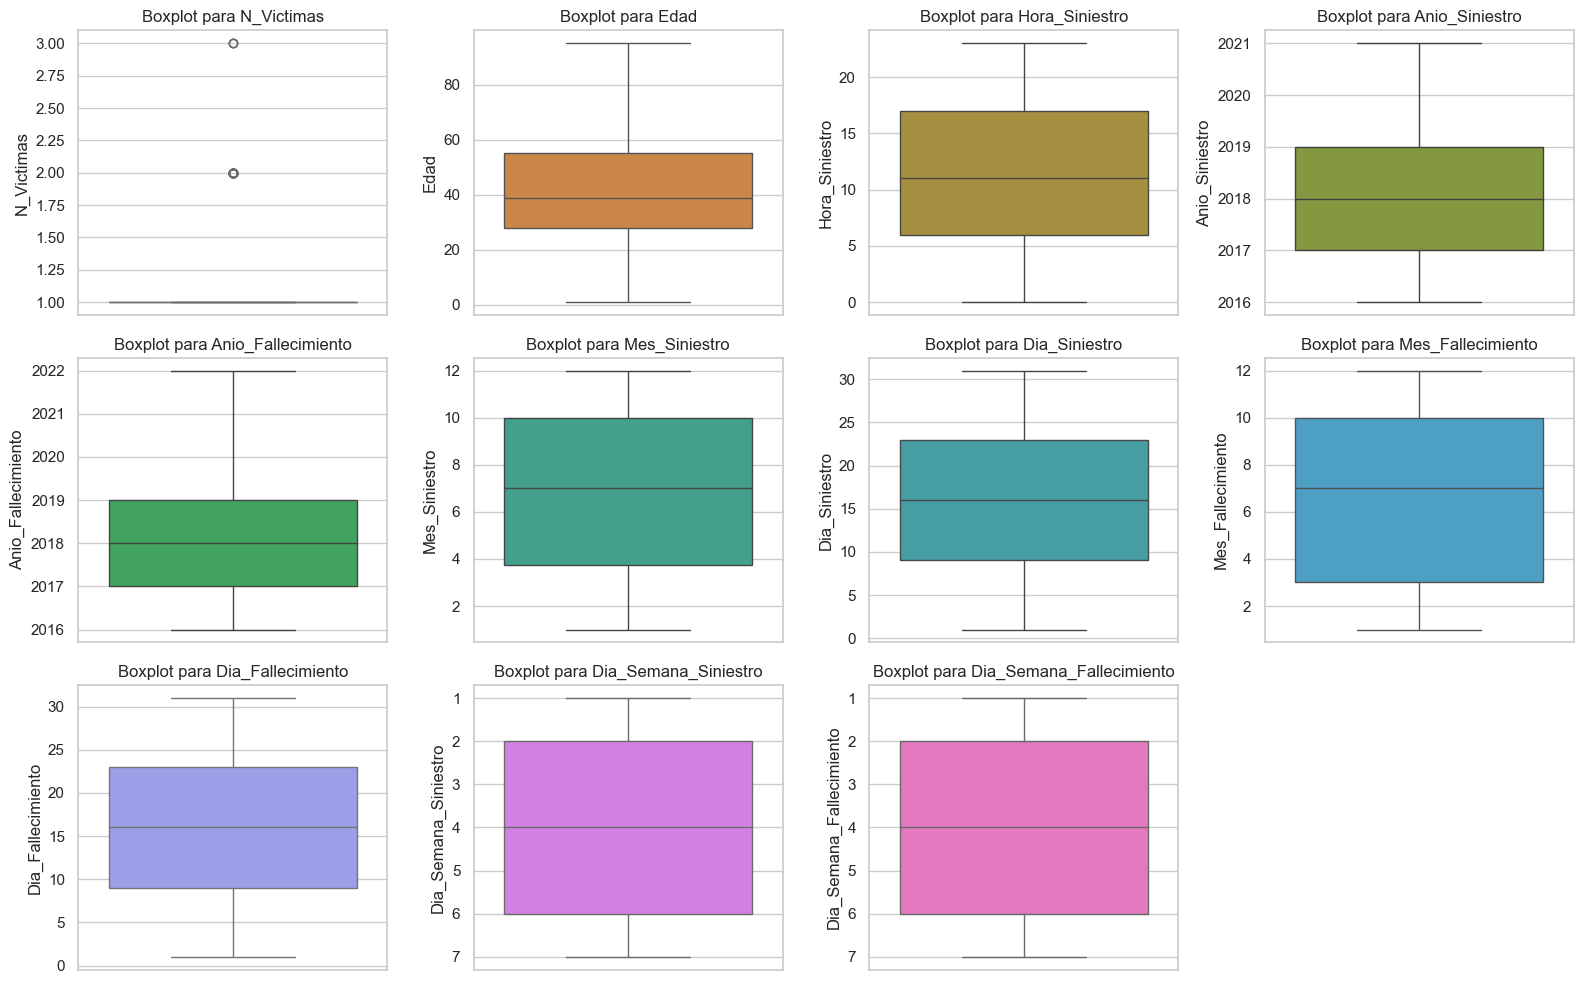

In [6]:
# Boxplots horizontales con escalas individuales
plt.figure(figsize=(16, 10))
sns.set(style="whitegrid")

#  columnas numéricas para los boxplots
columnas_numericas = [
    'N_Victimas', 'Edad', 'Hora_Siniestro', 'Anio_Siniestro', 'Anio_Fallecimiento', 'Mes_Siniestro', 'Dia_Siniestro',
    'Mes_Fallecimiento', 'Dia_Fallecimiento', 'Dia_Semana_Siniestro', 'Dia_Semana_Fallecimiento'
]

# paleta de colores para cada boxplot
colores = sns.color_palette("husl", len(columnas_numericas))

# crear el bucle para crear los boxplots horizontales con escalas individuales
for i, (columna, color) in enumerate(zip(columnas_numericas, colores)):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(y=df_siniestros_temp2[columna], color=color)
    plt.title(f"Boxplot para {columna}")
    plt.tight_layout()

plt.show()


En este caso los gráficos nos sirven para observar que los datos tienen escalas muy distintas. Hay "outliers" en el Número de victimas, pero ocurre sólo porque, como vimos en los descriptivos, el 75% de los datos tiene 1 como valor. Aunque no lo parece, saber que las escalas son distintas será útil para pensar en transformar los datos para compararlos en escalas comunes y encontrar correlaciones.  

### 1.2 Variables tratadas como categóricas

Pasamos ahora a observar las columnas que mantuvimos como categóricas. En este caso nos concentraremos en ver el top 5 (o menos) de aquellas categorías con mayor frecuencia.

In [7]:
# Cuenta de Valores Únicos para Columnas Categóricas
print("\nCuenta de Valores Únicos para Columnas Categóricas:")

columnas_categoricas = ["Sexo",'Tipo_De_Calle', 'Comuna', 'Victima', 'Acusado', 'Rol', 'Semestre']

for columna in columnas_categoricas:
    desc_categoria = pd.Series(df_siniestros_temp2[columna].astype(str).value_counts().to_dict(), name=columna).nlargest(5)

    # Imprimir resultados
    print(f"\nTop 5 Frecuencias para {columna}:")
    print(desc_categoria)


Cuenta de Valores Únicos para Columnas Categóricas:

Top 5 Frecuencias para Sexo:
2    536
1    166
3      2
Name: Sexo, dtype: int64

Top 5 Frecuencias para Tipo_De_Calle:
AVENIDA      510
CALLE        136
AUTOPISTA     58
Name: Tipo_De_Calle, dtype: int64

Top 5 Frecuencias para Comuna:
1    93
4    76
9    72
8    67
7    61
Name: Comuna, dtype: int64

Top 5 Frecuencias para Victima:
Moto         294
Peaton       263
Auto          91
Bicicleta     29
Sd             8
Name: Victima, dtype: int64

Top 5 Frecuencias para Acusado:
Auto           208
Pasajeros      177
Cargas         144
Objeto Fijo     66
Moto            58
Name: Acusado, dtype: int64

Top 5 Frecuencias para Rol:
CONDUCTOR               323
PEATON                  264
PASAJERO_ACOMPAÑANTE     79
CICLISTA                 29
SD                        9
Name: Rol, dtype: int64

Top 5 Frecuencias para Semestre:
2    365
1    339
Name: Semestre, dtype: int64


En primer lugar, se observa que son hombres quienes están involucrados en la mayor cantidad de siniestros viales como victimas.

En Tipo de calle predomina ampliamente la categoría "Avenida" con 511 casos, seguida por "Calle" con 138. Para la variable Comuna destacan los valores 1, 4, 9, 8 y 7, en éstas comunas ocurren entre 62-93 casos; de manera más específica  la comuna No. 1 destaca un poco del resto.

En cuanto a Víctima, se observa que la mayor cantidad de siniestros le ocurren a personas que conducen motocicletas (302 registros), seguida por "Peatón" con 266. Mientras la variable acusado muestra que el probable responsable es mayoritariamente un conductor de auto (210).

Por su parte, la variable Rol muestra que la mayor cantidad de siniestros ocurren a las personas mientras conducen (330) y en segundo lugar mientras transitan por la calle "Peatón" (267). Finalmente, para Semestre se observa una frecuencia ligeramente mayor en el segundo semestre con 370 casos versus 347 del primero.

## 2. Graficos generales

### Distribución de edad por sexo

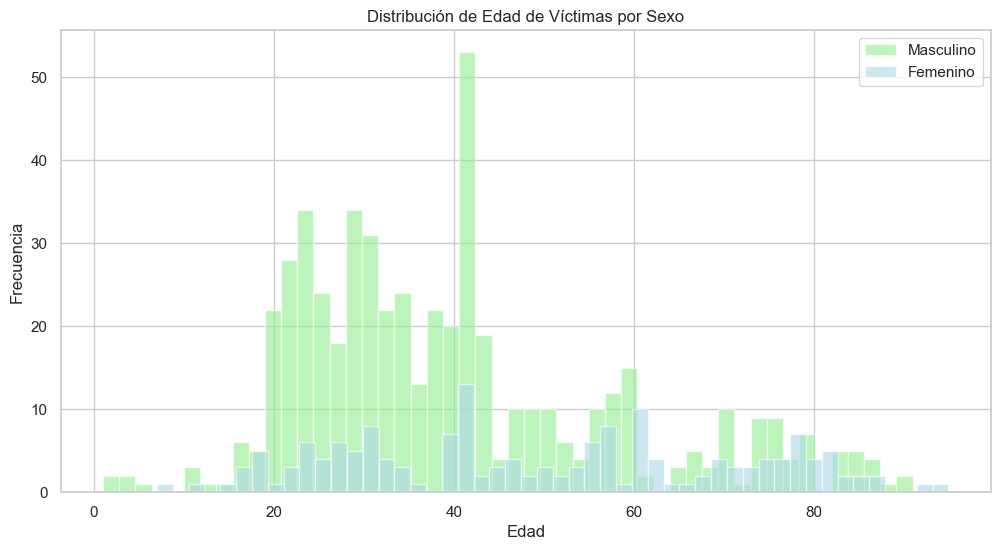

In [8]:
# Filtrar por sexo masculino y eliminar valores iguales a 0
masculino = df_siniestros[(df_siniestros['Sexo'] == 'MASCULINO') & (df_siniestros['Edad'] != 0)]['Edad'].dropna()

# Filtrar por sexo femenino y eliminar valores iguales a 0
femenino = df_siniestros[(df_siniestros['Sexo'] == 'FEMENINO') & (df_siniestros['Edad'] != 0)]['Edad'].dropna()

# Crear el histograma
plt.figure(figsize=(12, 6))
plt.hist(masculino, bins=50, alpha=0.6, color='lightgreen', label='Masculino', density=False)
plt.hist(femenino, bins=50, alpha=0.6, color='lightblue', label='Femenino', density=False)
plt.title('Distribución de Edad de Víctimas por Sexo')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()


La gráfica muestra la distribución por edad y género de las víctimas. Se observa que los hombres jóvenes entre 20 y 40 años son los más afectados, con un valor modal claramente remarcado en los 40 años. En contraste, en las mujeres la mayor frecuencia se da entre los 40 y 60 años. Esto sugiere patrones diferentes en que hombres y mujeres se ven involucrados en siniestros viales. Resalta con claridad el hecho de que en los hombres la frecuencia de incidentes disminuye con la edad, mientras que en las mujeres se mantiene relativamente estable.

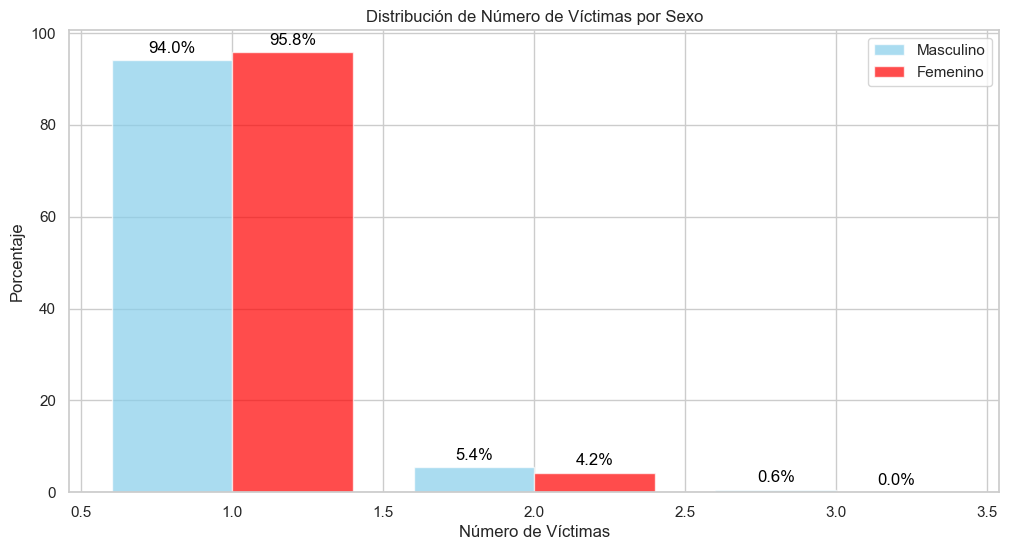

In [9]:
# Crear un DataFrame auxiliar para no modificar el original
df_temporal = df_siniestros.copy()

# Convertir la variable N_Victimas a categórica
df_temporal['N_Victimas'] = df_temporal['N_Victimas'].astype('category')

# Filtrar por sexo masculino
masculino = df_temporal[df_temporal['Sexo'] == 'MASCULINO']['N_Victimas'].value_counts(normalize=True).sort_index() * 100

# Filtrar por sexo femenino
femenino = df_temporal[df_temporal['Sexo'] == 'FEMENINO']['N_Victimas'].value_counts(normalize=True).sort_index() * 100

# Convertir los índices a valores numéricos
masculino_index = pd.to_numeric(masculino.index) - 0.2
femenino_index = pd.to_numeric(femenino.index) + 0.2

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))

# Barra para sexo masculino
plt.bar(masculino_index, masculino.values, width=0.4, alpha=0.7, color='skyblue', label='Masculino')

# Barra para sexo femenino
plt.bar(femenino_index, femenino.values, width=0.4, alpha=0.7, color='red', label='Femenino')

# Agregar etiquetas con porcentajes encima de cada barra
for i, value in zip(masculino_index, masculino.values):
    plt.text(i, value + 1, f'{value:.1f}%', ha='center', va='bottom', color='black')

for i, value in zip(femenino_index, femenino.values):
    plt.text(i, value + 1, f'{value:.1f}%', ha='center', va='bottom', color='black')

plt.title('Distribución de Número de Víctimas por Sexo')
plt.xlabel('Número de Víctimas')
plt.ylabel('Porcentaje')
plt.legend()
plt.show()

# Descartar el DataFrame auxiliar
del df_temporal


Respecto al número de victimas. Como habíamos visto en estadisticos anteriores, casi la totalidad de los incidentes involucran una sola víctima. Un porcentaje muy reducido involucran a más de dos y los incidentes con más de tres víctimas son casi inexistentes en el caso de los hombres y nulos en el caso de las mujeres. Aunque lo cierto es que cada fila de los datos indica una única categoría de sexo en vez de las posibles combinaciones de las víctimas; sería necesario ahondar más para saber si, en el conteo, necesariamente todas las víctimas reportadas son del mismo sexo.

### Distribución espacial

C:\Users\Eduardo\AppData\Local\Temp\ipykernel_4256\2633457506.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colores_comunas = plt.cm.get_cmap('Pastel1', len(comunas))


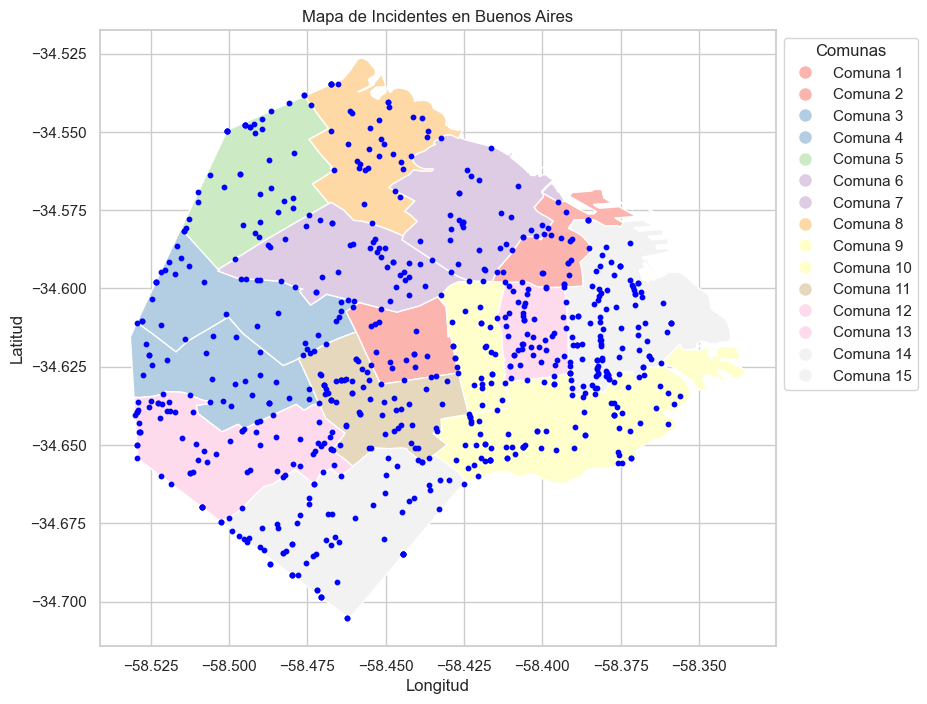

In [10]:
# Filtrar las filas con valores no nulos y distintos de 0.0 en Pos_X y Pos_Y y excluye Comuna igual a 0
df_siniestros_filtered = df_siniestros[(df_siniestros["Pos_X"] != 0.0) & (df_siniestros["Pos_Y"] != 0.0) & (df_siniestros["Comuna"] != 0)]

# Crear un GeoDataFrame a partir de las columnas de latitud y longitud del DataFrame filtrado
gdf = gpd.GeoDataFrame(df_siniestros_filtered, geometry=gpd.points_from_xy(df_siniestros_filtered['Pos_X'], df_siniestros_filtered['Pos_Y']))

# Cargar los límites de las comunas de Buenos Aires 
comunas = gpd.read_file('Comunas/comunas_wgs84.shp')

# Crear el mapa
fig, ax = plt.subplots(figsize=(10, 8))

# Dibuja las comunas y asigna un color único a cada una
colores_comunas = plt.cm.get_cmap('Pastel1', len(comunas))
comunas.plot(ax=ax, color=colores_comunas.colors)

# Dibuja los puntos de siniestros del DataFrame filtrado, asignando un solo color
gdf.plot(ax=ax, color='blue', markersize=10, label='Puntos de Siniestros')


ax.set_title('Mapa de Incidentes en Buenos Aires')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')

# Crea leyenda fuera del área del mapa para las comunas
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=f'Comuna {i+1}') for i, color in enumerate(colores_comunas.colors)]
ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1), title='Comunas')


# Muestra el mapa sin leyenda incorporada
plt.show()


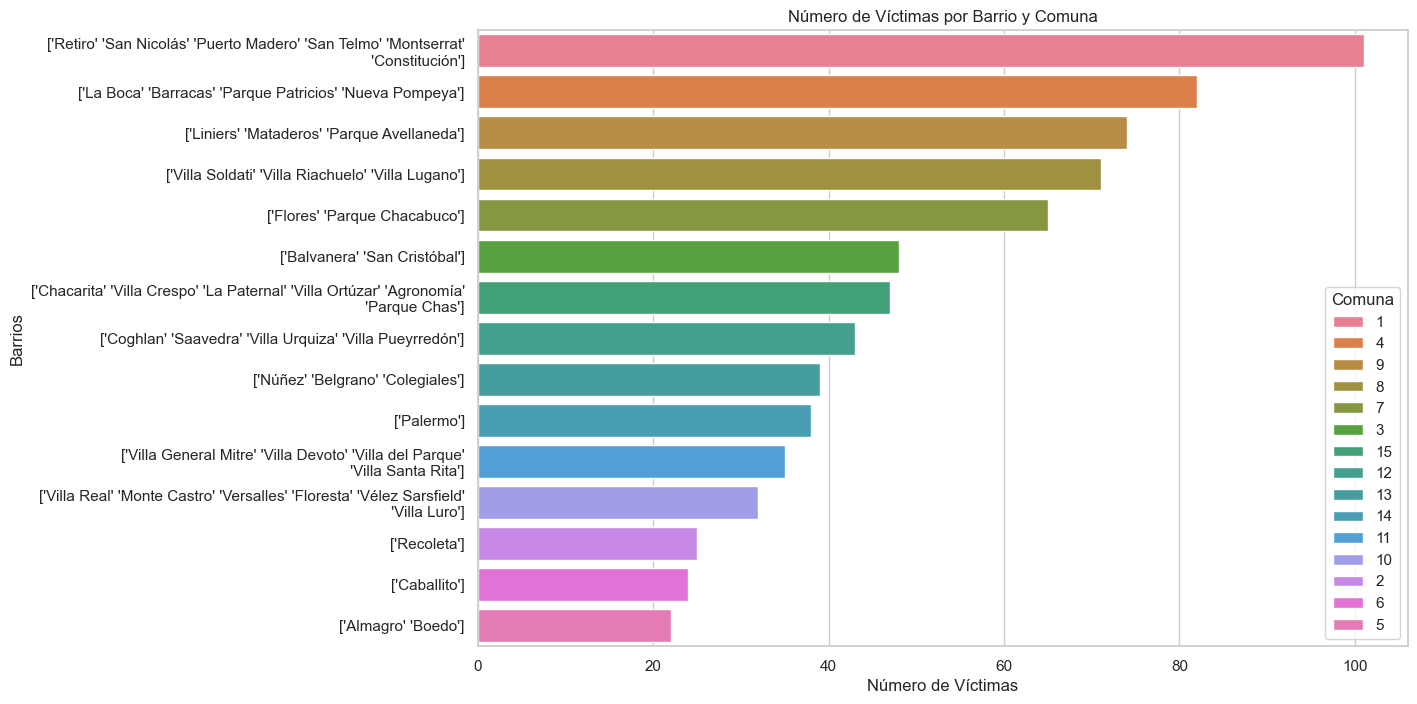

In [11]:

df_siniestros_aux = df_siniestros.copy()


df_siniestros_aux['Comuna'] = df_siniestros_aux['Comuna'].astype(str)
df_siniestros_aux['Barrios'] = df_siniestros_aux['Barrios'].astype(str)

df_siniestros_aux.dropna(subset=['Comuna', 'Barrios', 'N_Victimas'], inplace=True)

Total_comuna = df_siniestros_aux.groupby(["Comuna", "Barrios"])["N_Victimas"].sum().reset_index()
Total_comuna = Total_comuna.sort_values(by="N_Victimas", ascending=False)

sns.set_theme(style="whitegrid")
sns.set_palette("pastel")

# Crear la gráfica de barras
plt.figure(figsize=(12, 8))
bar_plot = sns.barplot(x="N_Victimas", y="Barrios", hue="Comuna", data=Total_comuna)
bar_plot.set_title('Número de Víctimas por Barrio y Comuna')
plt.xlabel('Número de Víctimas')
plt.ylabel('Barrios')
plt.legend(title='Comuna')

# Mostrar la gráfica
plt.show()


A partir de la representación espacial y del gráfico de barras se puede notar que hay 5 comunas que concentran significativamente más victimas que otras: se trata de las comunas 1,4, 9, 8 y 7. No parece haber un patrón claro en torno a la región en que suceden los incidentes.


### Distribución temporal: año, mes y día

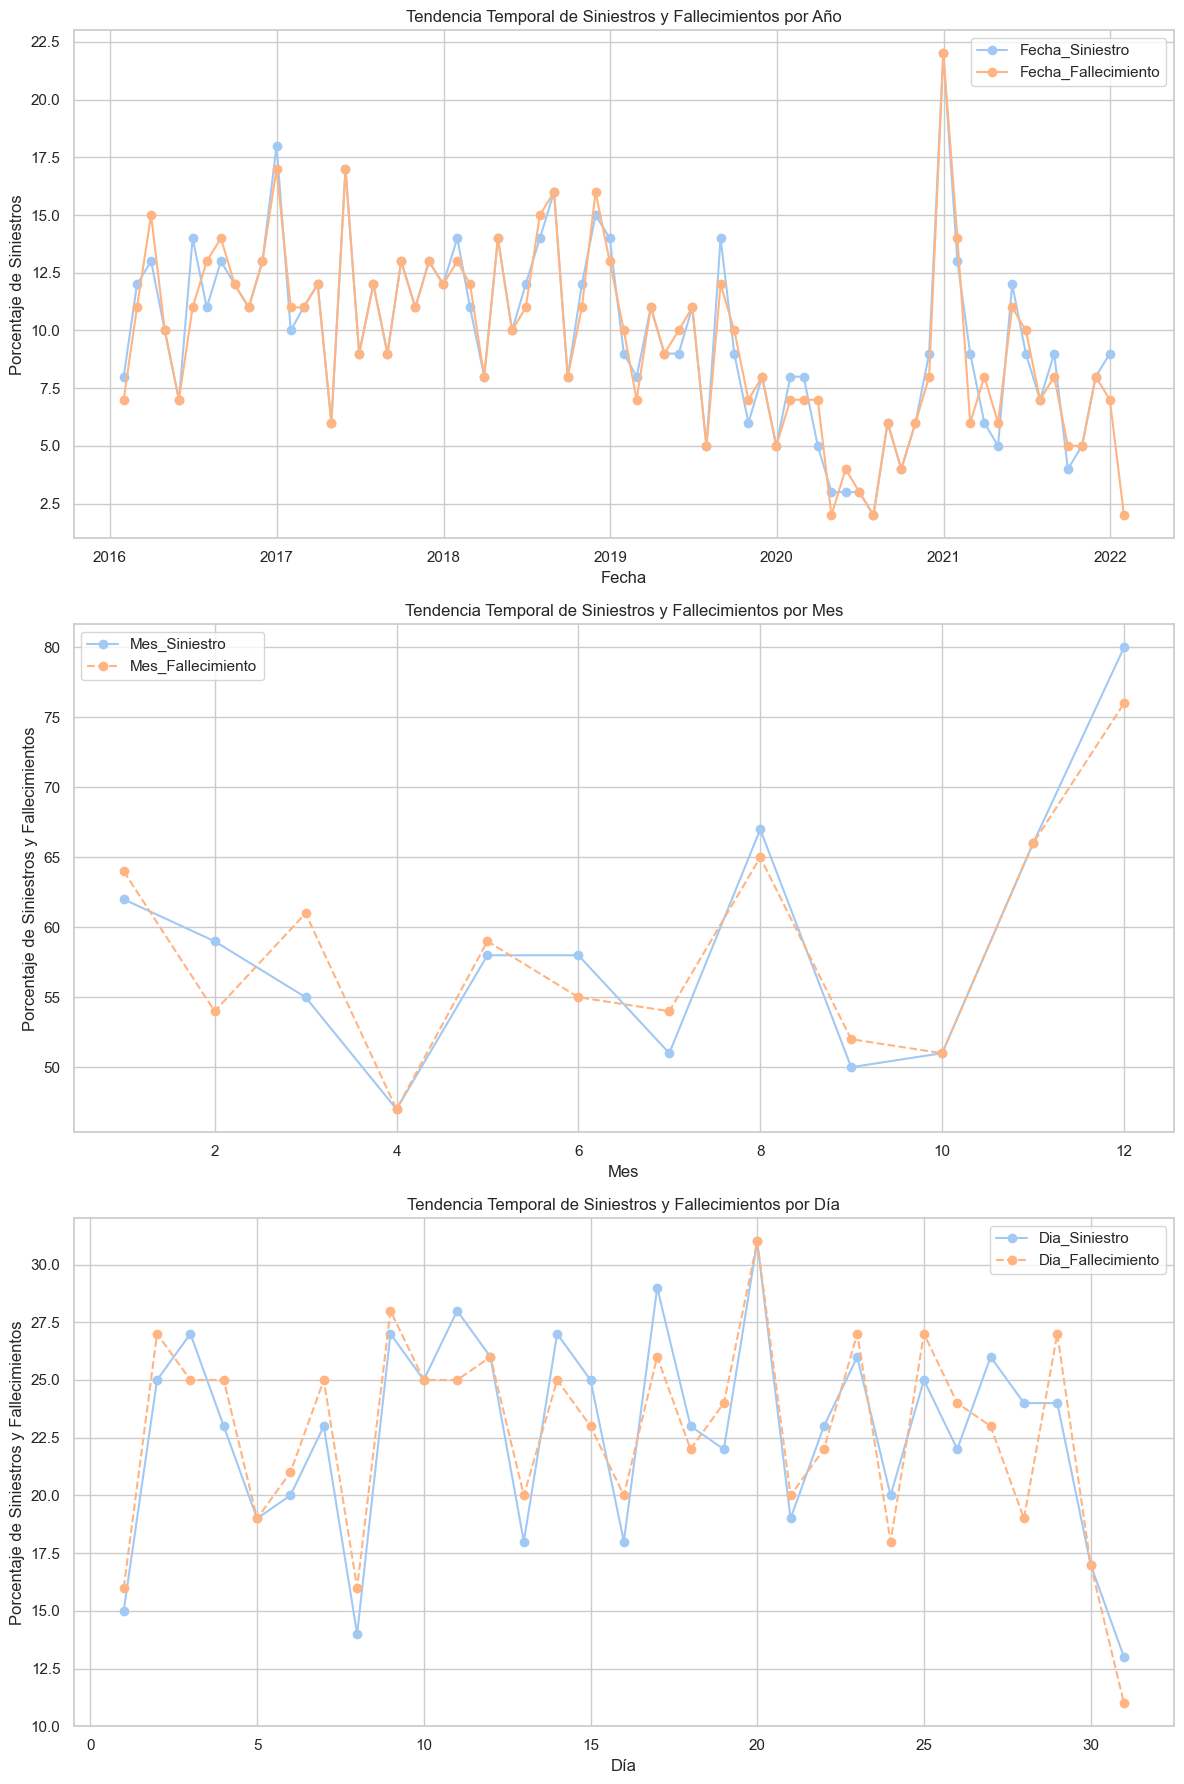

In [12]:
# Crear un DataFrame auxiliar para no modificar el original
df_aux = df_siniestros.copy()
df_aux = df_aux.set_index('Fecha_Siniestro').sort_index()

# Crear un DataFrame auxiliar para no modificar el original
df_aux_fallecimiento = df_siniestros.copy()
df_aux_fallecimiento = df_aux_fallecimiento.set_index('Fecha_Fallecimiento').sort_index()

# Agrupar por mes y contar la frecuencia para Fecha_Siniestro
df_resample_siniestro = df_aux.resample('M').size()

# Agrupar por mes y contar la frecuencia para Fecha_Fallecimiento
df_resample_fallecimiento = df_aux_fallecimiento.resample('M').size()

# Configurar el estilo de seaborn
sns.set_style("whitegrid")

# Crear subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 18))

# Gráfico 1: Tendencia temporal de Siniestros y Fallecimientos por Año
axs[0].plot(df_resample_siniestro, label='Fecha_Siniestro', marker='o')
axs[0].plot(df_resample_fallecimiento, label='Fecha_Fallecimiento', marker='o')
axs[0].set_xlabel('Fecha')
axs[0].set_ylabel('Porcentaje de Siniestros')
axs[0].set_title('Tendencia Temporal de Siniestros y Fallecimientos por Año')
axs[0].legend()

# Gráfico 2: Tendencia temporal de Siniestros y Fallecimientos por Mes
df_siniestros['Mes_Siniestro'].value_counts().sort_index().plot(ax=axs[1], label='Mes_Siniestro', marker='o', linestyle='-')
df_siniestros['Mes_Fallecimiento'].value_counts().sort_index().plot(ax=axs[1], label='Mes_Fallecimiento', marker='o', linestyle='--')
axs[1].set_xlabel('Mes')
axs[1].set_ylabel('Porcentaje de Siniestros y Fallecimientos')
axs[1].set_title('Tendencia Temporal de Siniestros y Fallecimientos por Mes')
axs[1].legend()

# Gráfico 3: Tendencia temporal de Siniestros y Fallecimientos por Día
df_siniestros['Dia_Siniestro'].value_counts().sort_index().plot(ax=axs[2], label='Dia_Siniestro', marker='o', linestyle='-')
df_siniestros['Dia_Fallecimiento'].value_counts().sort_index().plot(ax=axs[2], label='Dia_Fallecimiento', marker='o', linestyle='--')
axs[2].set_xlabel('Día')
axs[2].set_ylabel('Porcentaje de Siniestros y Fallecimientos')
axs[2].set_title('Tendencia Temporal de Siniestros y Fallecimientos por Día')
axs[2].legend()

plt.tight_layout()
plt.show()

# Descartar los DataFrames auxiliares
del df_aux, df_aux_fallecimiento


Respecto a la distribución tempora, en primer lugar se aprecia gran concordancia entre las fechas en que ocurrieron los siniestros y las fechas de fallecimiento (esto se discutirá con mayor detalle más adelante). Por otro lado, a nivel de año se aprecian fluctiaciones sin un patrín muy claro quizñas hasta 2020, y en el que destacan algúnos momentos específicos. Por ejemplo se nota que Enero y junio de 2017, así como enero de 2021 fueron momentos en que la frecuencia de los siniestros fue muy distinta al resto del periodo analizado. Esto podría indicar eventos anormales. En el caso del pico de 2021 es posible notar una tendencia a la baja durante 2020 que, quitando el pico observado, continúo durante 2021; misma que podría deberse al confinamiento durante la pandemia de COVID, el cual redujo el tránsito de las personas a través de diversos medios. El pico podría estar relacionado con el aumento de salidas por las fiestas decembrinas, y la identidad entre la cantidad de siniestros y fallecimientos podría deberse a la saturación de hospitales en ese mes.


La segunda gráfica sugiere la presencia de patrones estacionales, como se evidencia por los aumentos y disminuciones periódicos en el número de siniestros y fallecimientos a lo largo de los meses. Ambos: siniestros y fallecimientos parecen tener un pico significativo hacia el final del año (mes 12), lo que podría indicar una tendencia estacional o un evento específico que conduzca a un aumento en estos incidentes (como la existencia de vaciones o la urgencia de reuniones por fiestas compartidas).

La gráfica muestra que el porcentaje de accidentes y muertes fluctúa a lo largo del mes, con algunos picos y valles. Los picos más altos están en los días 17 y 20, mientras que las caídas ocurren en el día 8 y 31. La caída del día 31 se explica por la disminución en la cantidad de meses que tienen ese número de días, mientras que no hay una respuesta que, a priori, parezca clara para explicar la caída del día 8.  

## 3. Matriz de correlación para orientar revisión específica

Para orientar la revisión de "interacciones específicas" se va a realizar primero una matriz de correlación.
Debido a que el rango de las variables continuas varía bastante es necesario aplicar una transformación logarítmica para alinear las escalas numéricas a proporciones comparables y realizar correctamente la matriz de correlación, esto con el fin de intentar descubrir relaciones valiosas entre los datos.

La transformación es necesaria porque, por ejemplo, hay variables como el número de víctimas que originalmente presentan diferencias absolutas pequeñas entre sus valores extremos (de 1 a 3 víctimas). Sin embargo, estas diferencias absolutas no reflejan adecuadamente que el valor máximo es apenas tres veces más grande que el mínimo; mientras que, en la variable "Mes" la diferencia entre los valores mínimo y máximo (1 a 12) es bastamte más amplia en términos de su propia escala, situación que ocurre con las demás variables también. Es así que la transformación permite que las correlación entre variables se realice entre escalas con proporciones comparables.

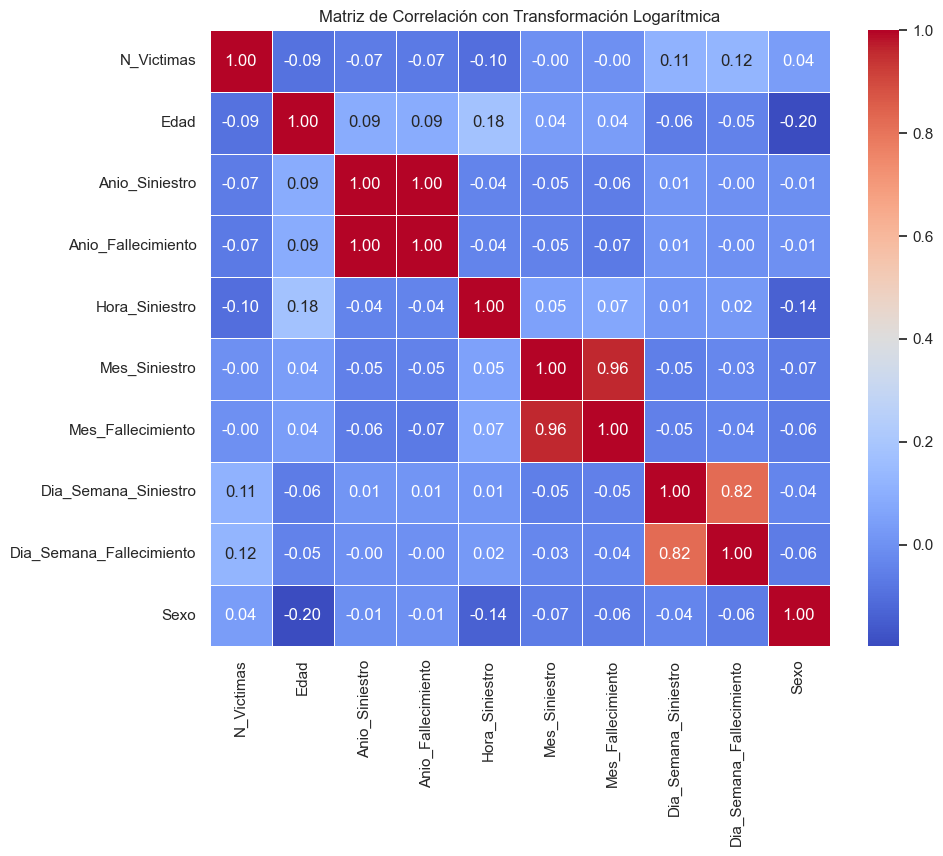

In [13]:
# Procesamiento de fechas y días de la semana
df_siniestros['Dia_Semana_Siniestro'] = df_siniestros['Fecha_Siniestro'].dt.dayofweek
df_siniestros['Dia_Semana_Fallecimiento'] = df_siniestros['Fecha_Fallecimiento'].dt.dayofweek

columnas_correlacion = ["N_Victimas", 'Edad', "Anio_Siniestro", "Anio_Fallecimiento", 'Hora_Siniestro', 'Mes_Siniestro', 'Mes_Fallecimiento',
                         'Dia_Semana_Siniestro', 'Dia_Semana_Fallecimiento', "Sexo"]

# Mapear "FEMENINO" a 1, "MASCULINO" a 2, y cualquier otro valor a NaN
df_siniestros['Sexo'] = df_siniestros['Sexo'].map({'FEMENINO': 1, 'MASCULINO': 2}).fillna(np.nan)

# Verificar si hay columnas no numéricas en columnas_correlacion y convertirlas
df_siniestros[columnas_correlacion] = df_siniestros[columnas_correlacion].apply(pd.to_numeric, errors='coerce')

# Eliminar filas con valores no numéricos en las columnas de interés
df_siniestros = df_siniestros.dropna(subset=columnas_correlacion)

# Aplicar transformación logarítmica a las variables
df_siniestros_log = np.log1p(df_siniestros[columnas_correlacion])

# Calcular la matriz de correlación para las variables transformadas
matriz_correlacion_log = df_siniestros_log.corr()

# Crear un mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_correlacion_log, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlación con Transformación Logarítmica')
plt.show()

# Restaurar los valores originales en la columna "Sexo"
df_siniestros['Sexo'] = df_siniestros['Sexo'].map({1: 'FEMENINO', 2: 'MASCULINO'})


Fuera de las correlaciones obvias (fallecimientos y siniestros) hay correlaciones que, si bien bajas, dan insights sobre algunos factores que pueden afectar la variabilidad del número de victimas. Podemos destacar lo siguiente:

En primer lugar, se observa una correlación negativa débil entre el número de víctimas y la edad (-0.096). Esto podría sugerir que los siniestros con mayor número de víctimas tienden a involucrar a personas más jóvenes. Ahondar en cómo varía la cantidad de víctimas entre diferentes rangos etarios puede arrojar más luz sobre esta relación.

También se aprecia una correlación negativa similar entre víctimas y hora del siniestro (-0.099). Esto podría indicar que ciertas franjas horarias están asociadas a una mayor probabilidad de siniestros con múltiples fallecidos. Analizar en detalle este factor temporal sería revelador para entender mejor este vínculo.  

En otro orden, existe una correlación positiva moderada (0.118) entre el número de víctimas y el día de la semana. Esto sugiere que la mortalidad puede fluctuar significativamente dependiendo del día en que ocurre el incidente. Desagregar por días específicos llevaría a comprender mejor cómo se relacionan estas dos variables.

Adicionalmente, hay una correlación positiva entre edad y hora del siniestro (0.176), indicando que el perfil etario parece variar según horario del siniestro. También se halló correlación negativa entre edad y sexo (-0.199), sugiriendo la existencia de diferencias demográficas de género que pueden ser relevantes para el análisis.

En resumen, la matriz de correlaciones permite identificar varias relaciones entre atributos que ameritan una investigación más exhaustiva mediante análisis gráficos, estadísticos y otros procedimientos. Seguir explorando estos vínculos tentativos será clave para obtener insights más profundos.

A continuación comenzaremos por analizar las relaciones descubiertas en este punto



## 4. Gráficos específicos

### Víctimas por días de la semana, segmento del día  y categorías de edad

In [14]:
# Agrupar las edades según la nueva clasificación
new_bins = [0, 14, 24, 45, 60, float('inf')]
new_labels = ['0-14 años', '15-24 años', '25-45 años', '46-60 años', '60 años o más']
df_siniestros['Edad_Categoria'] = pd.cut(df_siniestros['Edad'], bins=new_bins, labels=new_labels, right=False)

# Agrupa las horas del siniestro según la clasificación definida
# Madrugada de o a 6, mañana de 7 a 12, tarde de 13 a 18, noche de 19 a 24 hrs
hour_bins = [0, 6, 12, 18, 24]
hour_labels = ['Madrugada', 'Mañana', 'Tarde', 'Noche']
df_siniestros['Hora_Categoria'] = pd.cut(df_siniestros['Hora_Siniestro'], bins=hour_bins, labels=hour_labels, right=False)


In [15]:
# Mapear los números a los nombres de los días de la semana
dias_semana = {0: 'Lunes', 1: 'Martes', 2: 'Miércoles', 3: 'Jueves', 4: 'Viernes', 5: 'Sábado', 6: 'Domingo'}
df_siniestros['Dia_Semana_Siniestro'] = df_siniestros['Dia_Semana_Siniestro'].map(dias_semana)

# Crear una categoría ordenada para los días de la semana
dias_semana_ordenados = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
df_siniestros['Dia_Semana_Siniestro'] = pd.Categorical(df_siniestros['Dia_Semana_Siniestro'], categories=dias_semana_ordenados, ordered=True)

# Ordenar el DataFrame por la nueva columna categórica
df_siniestros.sort_values('Dia_Semana_Siniestro', inplace=True)

C:\Users\Eduardo\AppData\Local\Temp\ipykernel_4256\4159041466.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  porcentaje_dia = df_siniestros.groupby('Dia_Semana_Siniestro').size() / len(df_siniestros) * 100


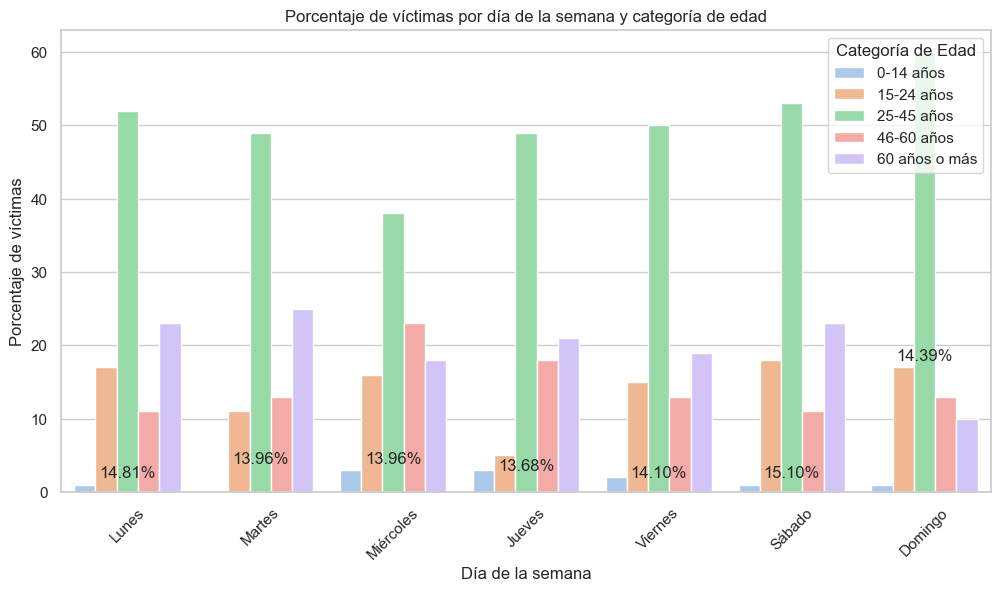

C:\Users\Eduardo\AppData\Local\Temp\ipykernel_4256\4159041466.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  porcentaje_hora = df_siniestros.groupby('Hora_Categoria').size() / len(df_siniestros) * 100


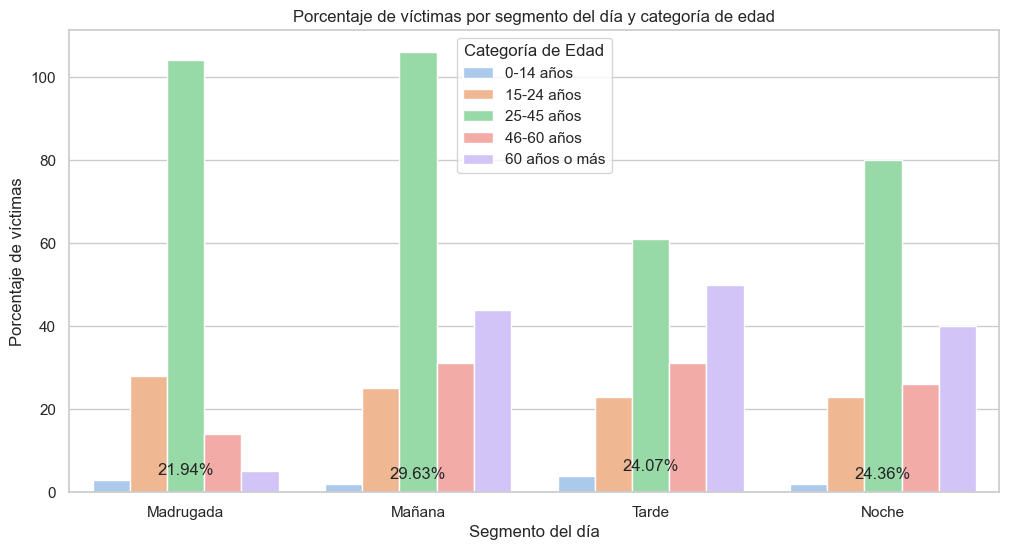

In [16]:

# Ajustes generales de estilo
sns.set(style="whitegrid")
sns.set_palette("pastel")

# Crear un gráfico de barras para visualizar el número de víctimas por día de la semana y categoría de edad
plt.figure(figsize=(12, 6))

# Gráfico de barras
ax = sns.countplot(x='Dia_Semana_Siniestro', data=df_siniestros, hue='Edad_Categoria', dodge=True)

# Añadir porcentaje de incidentes por día como texto en las barras
porcentaje_dia = df_siniestros.groupby('Dia_Semana_Siniestro').size() / len(df_siniestros) * 100
alturas_dia = [p.get_height() for p in ax.patches]

for idx, (value, altura) in enumerate(zip(porcentaje_dia, alturas_dia)):
    ax.text(idx, altura + 0.5, f'{value:.2f}%', ha='center', va='bottom')

plt.title('Porcentaje de víctimas por día de la semana y categoría de edad')
plt.xlabel('Día de la semana')
plt.ylabel('Porcentaje de víctimas')
plt.legend(title='Categoría de Edad')
plt.xticks(rotation=45)  # Rotar etiquetas del eje x para mayor legibilidad
plt.show()

# Crear un gráfico de barras para visualizar el número de víctimas por segmento del día y categoría de edad
plt.figure(figsize=(12, 6))
ax = sns.countplot(x='Hora_Categoria', data=df_siniestros, hue='Edad_Categoria', order=['Madrugada', 'Mañana', 'Tarde', 'Noche'], dodge=True)
plt.title('Porcentaje de víctimas por segmento del día y categoría de edad')
plt.xlabel('Segmento del día')
plt.ylabel('Porcentaje de víctimas')
plt.legend(title='Categoría de Edad')

# Añadir porcentaje de incidentes por día como texto en las barras (solo para la segunda gráfica)
porcentaje_hora = df_siniestros.groupby('Hora_Categoria').size() / len(df_siniestros) * 100
alturas_hora = [p.get_height() for p in ax.patches]

for idx, (value, altura) in enumerate(zip(porcentaje_hora, alturas_hora)):
    ax.text(idx, altura + 0.5, f'{value:.2f}%', ha='center', va='bottom')

plt.show()


La primera "Porcentaje de víctimas por día de la semana y categoría de edad" muestra el porcentaje de incidentes por día (el texto en la parte baja de las barras), donde se puede notar que la cantidad de incidentes no es muy distinta entre días de la semana, pues cada día concentra entre el 13 y el 15% de los incidentes. Sin embargo, al desagregar el porcentaje de incidentes en función de las categorías de edad que se crearon para este análisis, es posible obtener información que ya no es tan homogenea.

En primar lugar sobresale el hecho de que el grupo de 25 a 45 años es el que experimenta la mayor cantidad de incidentes mortales. Del mismo modo, en conjunto con el grupos de 15-24 años muestran picos más pronunciados durante el fin de semana; por su parte, al grupo de 60 años y más le ocurren más accidentes entre semana.

 En la segunda gráfica, "Porcentaje de incidentes por segmento del día", se observa que las personas entre 25 y 45 años tienen la mayor cantidad de incidentes durante la madrugada y la mañana. Mientras que el grupo de mayores de 60 años tiene el mayor porcentaje de víctimas por la tarde.

 Las tendencias podrían reflejar patrones de comportamiento social y actividad de los diferentes grupos de edad, como la vida nocturna, el trabajo, la escuela, o la exposición a diferentes riesgos en distintos momentos.

C:\Users\Eduardo\AppData\Local\Temp\ipykernel_4256\1716923694.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  porcentaje_hombres = df_masculino.groupby('Dia_Semana_Siniestro').size() / len(df_masculino) * 100
C:\Users\Eduardo\AppData\Local\Temp\ipykernel_4256\1716923694.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  porcentaje_mujeres = df_femenino.groupby('Dia_Semana_Siniestro').size() / len(df_femenino) * 100
C:\Users\Eduardo\AppData\Local\Temp\ipykernel_4256\1716923694.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pas

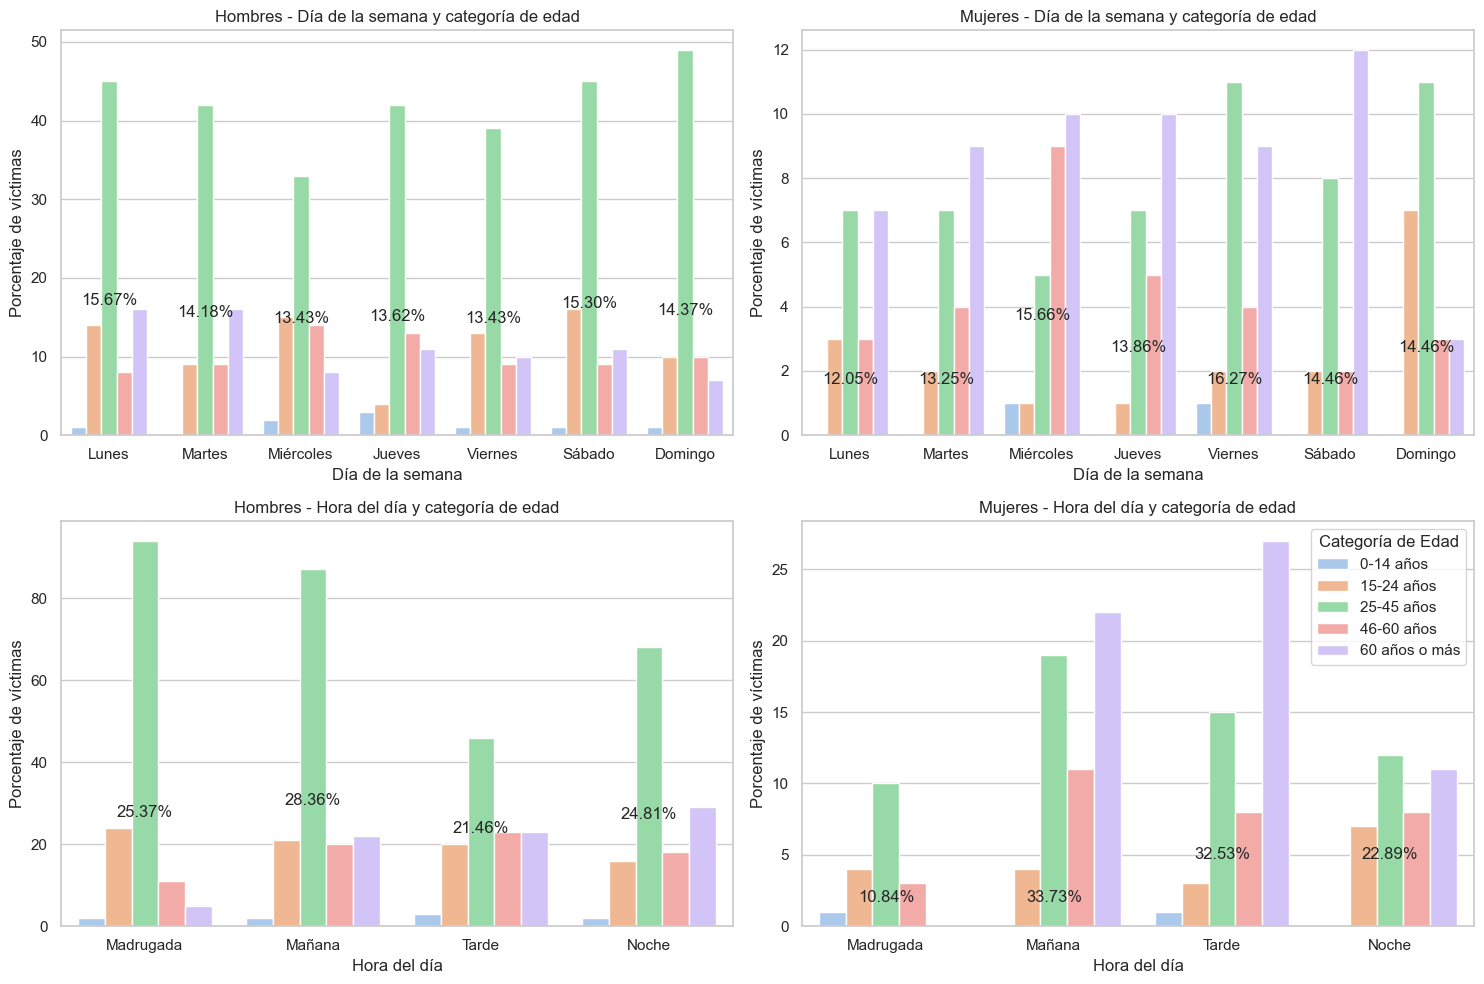

In [17]:
# Ajustes generales de estilo
sns.set(style="whitegrid")
sns.set_palette("pastel")

# Filtrar por género "MASCULINO"
df_masculino = df_siniestros[df_siniestros['Sexo'] == 'MASCULINO']

# Filtrar por género "FEMENINO"
df_femenino = df_siniestros[df_siniestros['Sexo'] == 'FEMENINO']

# Crear subplots para colocar los gráficos uno al lado del otro
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Gráfico 1 - Número de víctimas masculinas por día de la semana y categoría de edad
sns.countplot(x='Dia_Semana_Siniestro', data=df_masculino, hue='Edad_Categoria', ax=axs[0, 0], dodge=True)
axs[0, 0].set_title('Hombres - Día de la semana y categoría de edad')
axs[0, 0].set_xlabel('Día de la semana')
axs[0, 0].set_ylabel('Porcentaje de víctimas')
axs[0, 0].legend().set_visible(False)  # Eliminar la leyenda

# Calcular el porcentaje relativo de víctimas por día para hombres
porcentaje_hombres = df_masculino.groupby('Dia_Semana_Siniestro').size() / len(df_masculino) * 100

# Agregar el texto con el porcentaje en la parte central superior
for idx, value in enumerate(porcentaje_hombres):
    axs[0, 0].text(idx, value + 0.5, f'{value:.2f}%', ha='center', va='bottom')

# Gráfico 2 - Número de víctimas femeninas por día de la semana y categoría de edad
sns.countplot(x='Dia_Semana_Siniestro', data=df_femenino, hue='Edad_Categoria', ax=axs[0, 1], dodge=True)
axs[0, 1].set_title('Mujeres - Día de la semana y categoría de edad')
axs[0, 1].set_xlabel('Día de la semana')
axs[0, 1].set_ylabel('Porcentaje de víctimas')
axs[0, 1].legend().set_visible(False)  # Eliminar la leyenda

# Calcular el porcentaje relativo de víctimas por día para mujeres
porcentaje_mujeres = df_femenino.groupby('Dia_Semana_Siniestro').size() / len(df_femenino) * 100

# Obtener las alturas de las barras de las mujeres
alturas_mujeres = [p.get_height() for p in axs[0, 1].patches]

# Agregar el texto con el porcentaje en la parte superior de cada barra
for idx, (value, altura) in enumerate(zip(porcentaje_mujeres, alturas_mujeres)):
    axs[0, 1].text(idx, altura + 0.5, f'{value:.2f}%', ha='center', va='bottom')

# Gráfico 3 - Número de víctimas masculinas por hora del día y categoría de edad
sns.countplot(x='Hora_Categoria', data=df_masculino, hue='Edad_Categoria', ax=axs[1, 0], dodge=True)
axs[1, 0].set_title('Hombres - Hora del día y categoría de edad')
axs[1, 0].set_xlabel('Hora del día')
axs[1, 0].set_ylabel('Porcentaje de víctimas')
axs[1, 0].legend().set_visible(False)  # Eliminar la leyenda

# Calcular el porcentaje relativo de víctimas por hora para hombres
porcentaje_hombres_hora = df_masculino.groupby('Hora_Categoria').size() / len(df_masculino) * 100

# Agregar el texto con el porcentaje en la parte central superior
for idx, value in enumerate(porcentaje_hombres_hora):
    axs[1, 0].text(idx, value + 0.5, f'{value:.2f}%', ha='center', va='bottom')

# Gráfico 4 - Número de víctimas femeninas por hora del día y categoría de edad
sns.countplot(x='Hora_Categoria', data=df_femenino, hue='Edad_Categoria', ax=axs[1, 1], dodge=True)
axs[1, 1].set_title('Mujeres - Hora del día y categoría de edad')
axs[1, 1].set_xlabel('Hora del día')
axs[1, 1].set_ylabel('Porcentaje de víctimas')

# Añadir leyenda para la categoría de edad en la esquina superior derecha dentro del gráfico
handles, labels = axs[1, 1].get_legend_handles_labels()
axs[1, 1].legend(handles=handles, labels=labels, title='Categoría de Edad', bbox_to_anchor=(1, 1), loc='upper right')

# Calcular el porcentaje relativo de víctimas por hora para mujeres
porcentaje_mujeres_hora = df_femenino.groupby('Hora_Categoria').size() / len(df_femenino) * 100

# Obtener las alturas de las barras de las mujeres en el Gráfico 4
alturas_mujeres_hora = [p.get_height() for p in axs[1, 1].patches]

# Agregar el texto con el porcentaje en la parte superior de cada barra
for idx, (value, altura) in enumerate(zip(porcentaje_mujeres_hora, alturas_mujeres_hora)):
    axs[1, 1].text(idx, altura + 0.5, f'{value:.2f}%', ha='center', va='bottom')

# Ajustar el espacio entre los gráficos
plt.tight_layout()
plt.show()


Al desagregar los datos anteriores por sexo se encuentran hallazgos importantes.

Para los hombres, el mayor porcentaje de víctimas se presenta en el grupo de 25-45 años, especialmente hacia el final de la semana (sábado, domingo y lunes).

En las mujeres, el grupo de 25-45 años también muestra un pico los días sábado y domingo, pero con un porcentaje significativamente menor en comparación con los hombres. Sin embargo, lo más sobresaliente es que, en el caso de las mujeres, el grupo más expuesto a siniestros es el de personas mayores

Por otro lado, respecto a las diferencias por incidentes a lo largo del día, los hombres mantienen la tendencia general de la gráfica anterior, con el porcentaje de cada momento del día muy cercando entre sí; sin embargo, las mujeres se distancian de esa tendencia; pues muestran estar más expuestas a incidentes durante la mañana y durante la tarde, estos momentos concentral el 65% de las ocurrencias.  

### Tipos de Victimas, Acusados y Roles, por sexo

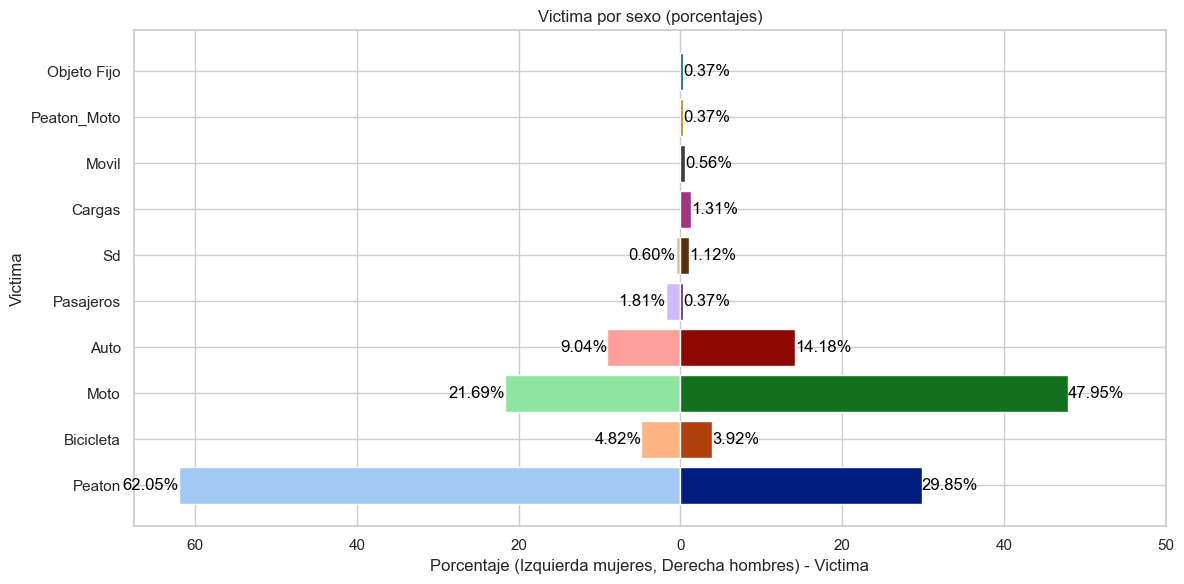

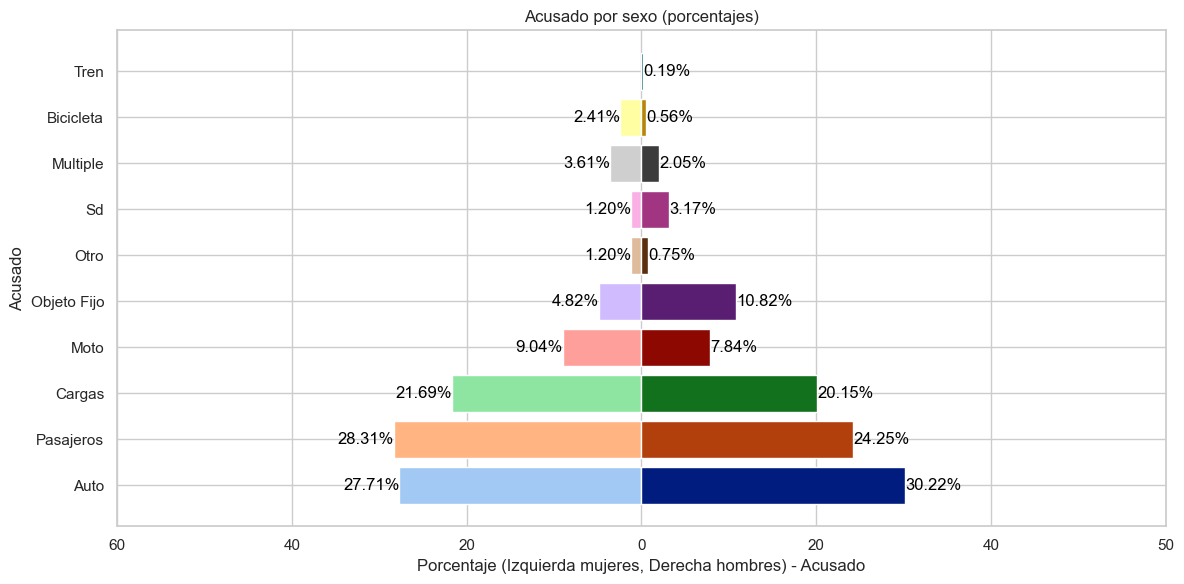

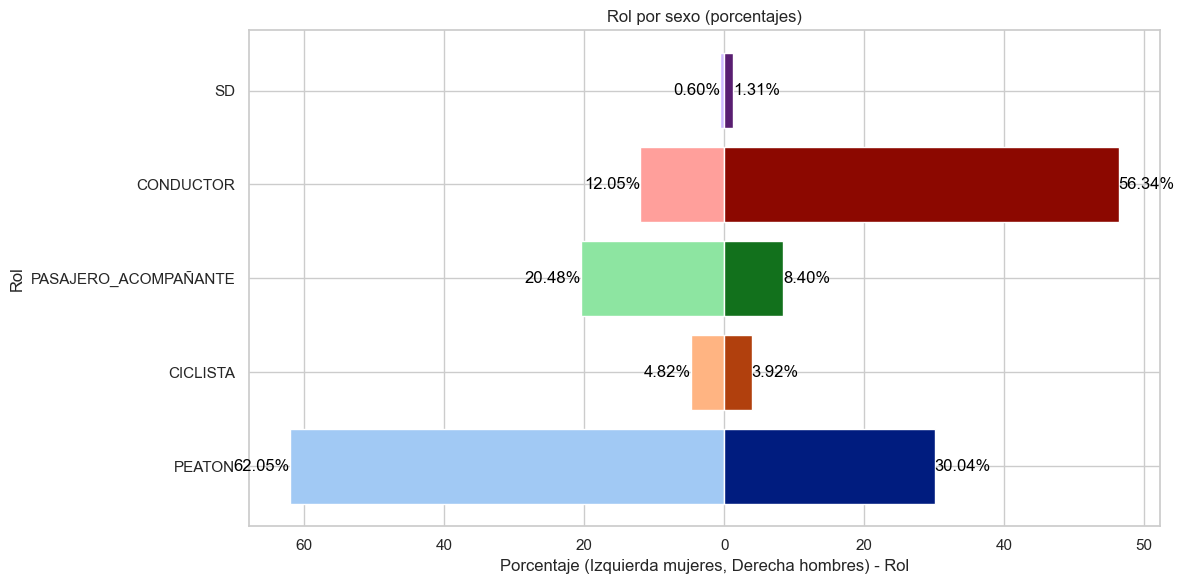

In [18]:
def generar_grafica_barras(df, variable, etiquetas_variable):
    # Calcular los porcentajes para cada género y variable
    porcentaje = df.groupby(['Sexo', variable]).size().unstack().T.div(df['Sexo'].value_counts(), axis=1).T * 100

    # Crear un mapa de colores distintos para mujeres y hombres
    colores_femenino = sns.color_palette("pastel", n_colors=len(etiquetas_variable))
    colores_masculino = sns.color_palette("dark", n_colors=len(etiquetas_variable))

    # Crear la gráfica de barras divergentes
    fig, ax = plt.subplots(figsize=(12, 6))

    # Gráfica para FEMENINO
    for i, (label, color) in enumerate(zip(etiquetas_variable, colores_femenino)):
        porcentaje_femenino = porcentaje.loc['FEMENINO', label]
        if pd.notna(porcentaje_femenino) and porcentaje_femenino != 0:
            ax.barh(label, -porcentaje_femenino, color=color, label=None)
            ax.text(-porcentaje_femenino, i, f'{porcentaje_femenino:.2f}%', ha='right', va='center', color='black')

    # Gráfica para MASCULINO
    for i, (label, color) in enumerate(zip(etiquetas_variable, colores_masculino)):
        porcentaje_masculino = porcentaje.loc['MASCULINO', label]
        if pd.notna(porcentaje_masculino) and porcentaje_masculino != 0:
            ax.barh(label, porcentaje_masculino, color=color, label=None)
            ax.text(porcentaje_masculino, i, f'{porcentaje_masculino:.2f}%', ha='left', va='center', color='black')

    # Ajustar la apariencia del eje X
    ax.xaxis.tick_bottom()
    ax.xaxis.set_tick_params(width=0)
    ax.set_xticks([-60, -40, -20, 0, 20, 40, 60])
    ax.set_xticklabels([60, 40, 20, 0, 20, 40, 50])

    # Añadir descripción en el eje x
    ax.set_xlabel(f'Porcentaje (Izquierda mujeres, Derecha hombres) - {variable}')
    ax.set_ylabel(variable)
    ax.set_title(f'{variable} por sexo (porcentajes)')

    plt.tight_layout()
    plt.show()

# Filtra los datos para incluir solo los valores de Sexo que son FEMENINO o MASCULINO
df_filtered = df_siniestros[df_siniestros['Sexo'].isin(['FEMENINO', 'MASCULINO'])]

# Variables de interés y etiquetas
variables_interes = ['Victima', 'Acusado', 'Rol']
etiquetas_variables = {
    'Victima': df_filtered['Victima'].unique(),
    'Acusado': df_filtered['Acusado'].unique(),
    'Rol': df_filtered['Rol'].unique()
}

# Generar gráficas de barras divergentes para cada variable de interés
for variable in variables_interes:
    generar_grafica_barras(df_filtered, variable, etiquetas_variables[variable])


La gráfica de victima por sexo muestra una diferencia clara en el tipo de incidentes mortales que más afectan a hombres y a mujeres. En el caos de los primeros, prácticamente la mitad de los sucesos les ocurren mientras conducen una motocicleta, mientras que a las mujeres les ocurren mientras caminan por la calle. Es por esta razón que, se elige tomar la reducción de los siniestros que involucran a mujeres (en calidad de peaton) como un kpi indispensable.

Por su parte, la gráfica de Acusados por sexo, otorga información complementaria a la anterior. En ambos caso, tanto hombres como mujeres, son en su mayoría víctimas de automoviles y pasajeros.

Finalmente, la gráfica de "Rol por sexo", complementa mejor a la de tipos de víctimas. En este caso, se añade la información de que las mujeres tienen muchos más incidentes siendo pasajeras que los hombres

### Víctima vs acusado, frecuencias

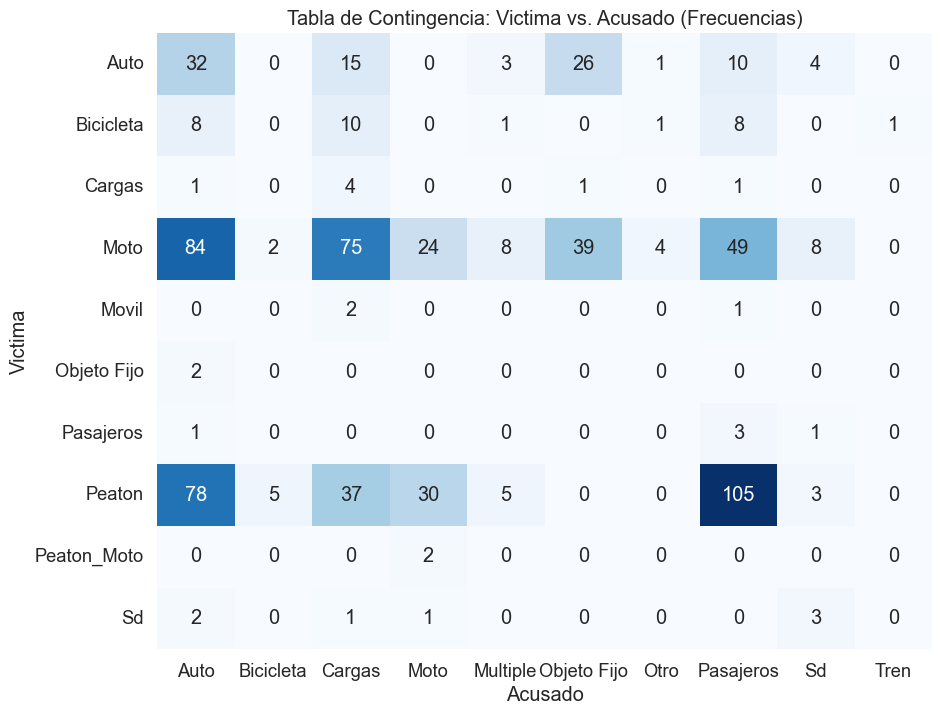

In [19]:
# Crear la tabla de contingencia
tabla_contingencia = pd.crosstab(df_siniestros['Victima'], df_siniestros['Acusado'])

# Configurar el estilo del mapa de calor
sns.set(font_scale=1.2)
plt.figure(figsize=(10, 8))

# Crear el mapa de calor
heatmap = sns.heatmap(tabla_contingencia, annot=True, cmap="Blues", fmt="d", cbar=False)

# Añadir etiquetas y título
plt.title('Tabla de Contingencia: Victima vs. Acusado (Frecuencias)')
plt.xlabel('Acusado')
plt.ylabel('Victima')

# Mostrar el mapa de calor
plt.show()


Se observa que hay algunas frecuencias más altas que otras en cuanto a la combinación de Acusados y Víctimas. Los autos y cargas generan más siniestros sobre Motos y peatones, aunque, sorpresivamente son los pasajeros quienes generan más siniestros en Peatones que cualquier otro acusado

### Tipo de calle por sexo

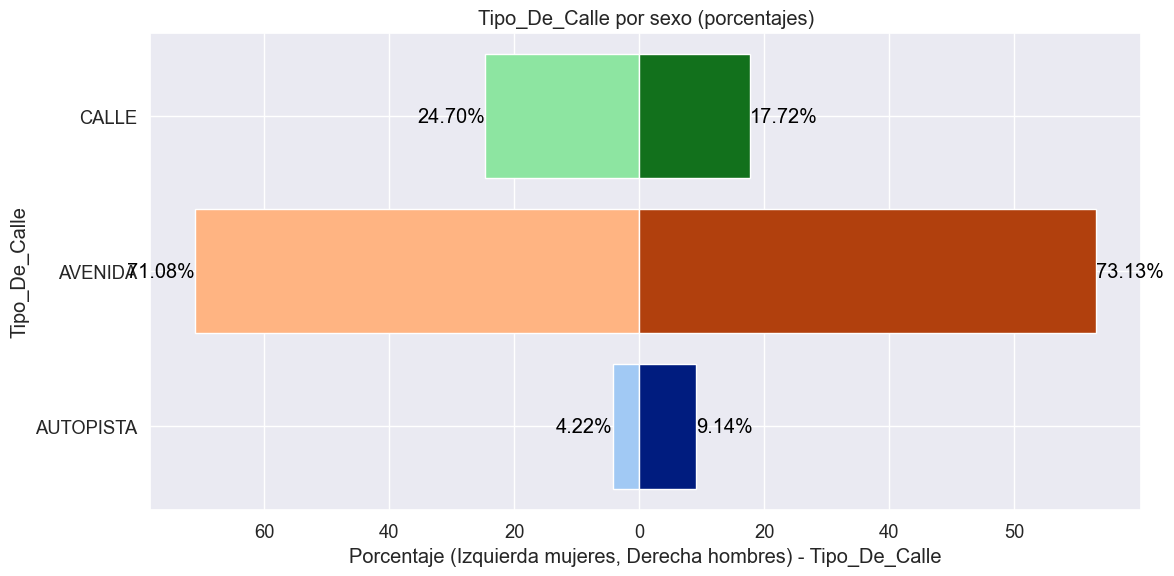

In [20]:
# Filtrar los datos para incluir solo los valores de Sexo que son FEMENINO o MASCULINO
df_filtered = df_siniestros[df_siniestros['Sexo'].isin(['FEMENINO', 'MASCULINO'])]

# Calcular los porcentajes para cada género y tipo de calle
porcentaje = df_filtered.groupby(['Sexo', 'Tipo_De_Calle']).size().unstack().T.div(df_filtered['Sexo'].value_counts(), axis=1).T * 100

# Crear un mapa de colores distintos para mujeres y hombres
colores_femenino = sns.color_palette("pastel", n_colors=len(df_filtered['Tipo_De_Calle'].unique()))
colores_masculino = sns.color_palette("dark", n_colors=len(df_filtered['Tipo_De_Calle'].unique()))

# Crear la gráfica de barras divergentes
fig, ax = plt.subplots(figsize=(12, 6))

# Gráfica para FEMENINO
for i, (label, color) in enumerate(zip(df_filtered['Tipo_De_Calle'].unique(), colores_femenino)):
    porcentaje_femenino = porcentaje.loc['FEMENINO', label]
    if pd.notna(porcentaje_femenino) and porcentaje_femenino != 0:
        ax.barh(label, -porcentaje_femenino, color=color, label=None)
        ax.text(-porcentaje_femenino, i, f'{porcentaje_femenino:.2f}%', ha='right', va='center', color='black')

# Gráfica para MASCULINO
for i, (label, color) in enumerate(zip(df_filtered['Tipo_De_Calle'].unique(), colores_masculino)):
    porcentaje_masculino = porcentaje.loc['MASCULINO', label]
    if pd.notna(porcentaje_masculino) and porcentaje_masculino != 0:
        ax.barh(label, porcentaje_masculino, color=color, label=None)
        ax.text(porcentaje_masculino, i, f'{porcentaje_masculino:.2f}%', ha='left', va='center', color='black')

# Ajustar la apariencia del eje X
ax.xaxis.tick_bottom()
ax.xaxis.set_tick_params(width=0)
ax.set_xticks([-60, -40, -20, 0, 20, 40, 60])
ax.set_xticklabels([60, 40, 20, 0, 20, 40, 50])

# Añadir descripción en el eje x
ax.set_xlabel('Porcentaje (Izquierda mujeres, Derecha hombres) - Tipo_De_Calle')
ax.set_ylabel('Tipo_De_Calle')
ax.set_title('Tipo_De_Calle por sexo (porcentajes)')

plt.tight_layout()
plt.show()


Respecto al tipo de calle, se observan algunas diferencias que son congruentes con los resultados anteriores. Las mujeres, que en su mayoría tienen incidentes siendo  peatones, tienen 7pp más de incidentes sobre calles que los hombres. Mientras que estos tienen 6pp más de incidentes en autopistas.

### Frecuencia de Siniestros y Fallecimientos por día Días de la Semana con promedio de días de diferencias entre uno y otro

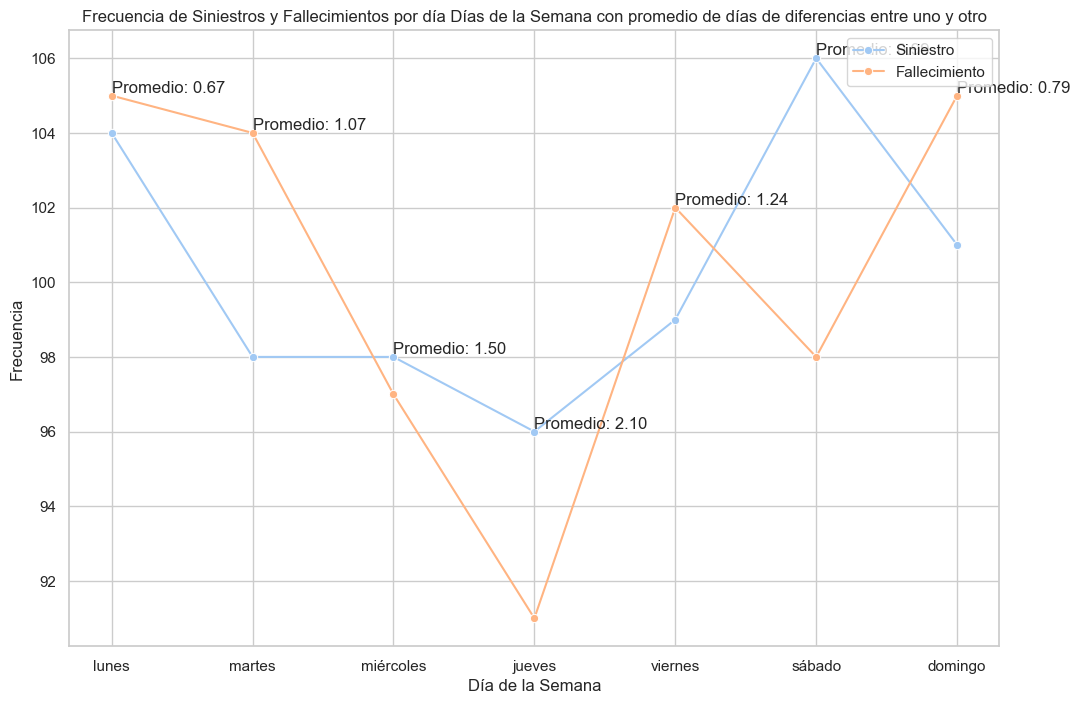

In [21]:
# Convertir las fechas a tipo de dato datetime
df_siniestros['Fecha_Siniestro'] = pd.to_datetime(df_siniestros['Fecha_Siniestro'])
df_siniestros['Fecha_Fallecimiento'] = pd.to_datetime(df_siniestros['Fecha_Fallecimiento'])

# Agregar una columna para el día de la semana del siniestro y de la muerte
df_siniestros['Dia_Semana_Siniestro'] = df_siniestros['Fecha_Siniestro'].dt.dayofweek
df_siniestros['Dia_Semana_Fallecimiento'] = df_siniestros['Fecha_Fallecimiento'].dt.dayofweek

# Calcular la diferencia en días
df_siniestros['Diferencia_Dias'] = (df_siniestros['Fecha_Fallecimiento'] - df_siniestros['Fecha_Siniestro']).dt.days

# Calcular el valor absoluto de las diferencias
df_siniestros['Diferencia_Dias_Abs'] = df_siniestros['Diferencia_Dias'].abs()

# Calcular el promedio de diferencias absolutas por día de la semana
promedio_diferencias_abs = df_siniestros.groupby('Dia_Semana_Siniestro')['Diferencia_Dias_Abs'].mean()

# Establecer el orden personalizado de los días de la semana
orden_dias_semana = ["lunes", "martes", "miércoles", "jueves", "viernes", "sábado", "domingo"]

# Contar la frecuencia de cada día de la semana
frecuencia_siniestro = df_siniestros['Dia_Semana_Siniestro'].value_counts().sort_index()
frecuencia_fallecimiento = df_siniestros['Dia_Semana_Fallecimiento'].value_counts().sort_index()

# Crear un DataFrame con las frecuencias
df_frecuencias = pd.DataFrame({
    'Dia_Semana': orden_dias_semana,
    'Frecuencia_Siniestro': frecuencia_siniestro.values,
    'Frecuencia_Fallecimiento': frecuencia_fallecimiento.values
})

# Configuraciones de estilo
sns.set(style="whitegrid")
sns.set_palette("pastel")

# Crear un gráfico de líneas
plt.figure(figsize=(12, 8))
sns.lineplot(x='Dia_Semana', y='Frecuencia_Siniestro', data=df_frecuencias, label='Siniestro', marker='o')
sns.lineplot(x='Dia_Semana', y='Frecuencia_Fallecimiento', data=df_frecuencias, label='Fallecimiento', marker='o')
plt.title('Frecuencia de Siniestros y Fallecimientos por día Días de la Semana con promedio de días de diferencias entre uno y otro')
plt.xlabel('Día de la Semana')
plt.ylabel('Frecuencia')
plt.legend()

# Añadir texto con los valores promedio en los puntos correspondientes
for i, valor in enumerate(promedio_diferencias_abs):
    plt.text(i, max(df_frecuencias['Frecuencia_Siniestro'][i], df_frecuencias['Frecuencia_Fallecimiento'][i]),
             f'Promedio: {valor:.2f}', ha='left', va='bottom')

plt.grid(True)
plt.show()


Finalmente, se presenta el análisis de la comparación entre la frecuencia de siniestros y muertes por día de la semana. En primer lugar se aprecia una clara separación entre la frecuencia de muertes por día  y la frecuencia de siniestros por día. Esto quiere decir, basicamente, que las personas que tienen incidentes mortales no mueren siempre el mismo día del incidente. La diferencia entre las frecuencias no es directamente interpretable debido a que la muerte y el siniestro se encuentran "desfasados" es por ello que se calculó el tiempo promedio en días que pasa entre el fallecimiento y el siniestro.

En este sentido la tendencia es clara. El tiempo promedio entre el siniestro y el fallecimiento es mayor de Martes a Viernes, es decir, entre semana; siendo el jueves el día con mayor diferencia. Esto puede significar dos cosas:


1.   Que los accidentes que ocurren durante la semana son "un poco menos graves", de manera que se prolonga la supervivencia un poco más. Mientras que el domingo (incluye la madrugada) y lunes, los siniestros son resultado de prácticas culturales que los vuelven más agresivos y con tiempos de supervivencia menores.

o

2.   Que el domingo y el lunes, por diversos motivos, la atención medica disminuye en calidad o capacidad, de manera que no es capaz de prolongar la vida durante más tiempo. Mientras que durante semana ocurre lo contrario.  



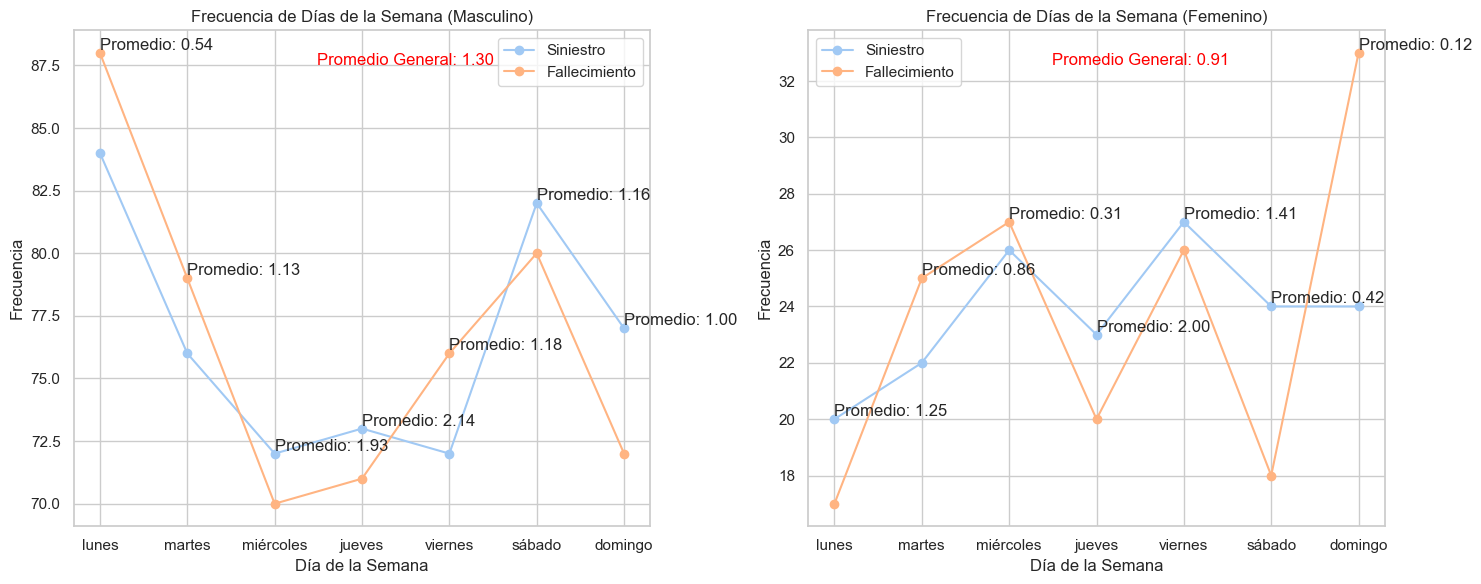

In [22]:
df_siniestros['Fecha_Siniestro'] = pd.to_datetime(df_siniestros['Fecha_Siniestro'])
df_siniestros['Fecha_Fallecimiento'] = pd.to_datetime(df_siniestros['Fecha_Fallecimiento'])

# Agregar una columna para el día de la semana del siniestro y de la muerte
df_siniestros['Dia_Semana_Siniestro'] = df_siniestros['Fecha_Siniestro'].dt.dayofweek
df_siniestros['Dia_Semana_Fallecimiento'] = df_siniestros['Fecha_Fallecimiento'].dt.dayofweek

# Calcular la diferencia en días
df_siniestros['Diferencia_Dias'] = (df_siniestros['Fecha_Fallecimiento'] - df_siniestros['Fecha_Siniestro']).dt.days

# Calcular el valor absoluto de las diferencias
df_siniestros['Diferencia_Dias_Abs'] = df_siniestros['Diferencia_Dias'].abs()

# Dividir el DataFrame por género
df_masculino = df_siniestros[df_siniestros['Sexo'] == 'MASCULINO']
df_femenino = df_siniestros[df_siniestros['Sexo'] == 'FEMENINO']

# Calcular el promedio de diferencias absolutas por día de la semana para ambos géneros
promedio_diferencias_abs_masculino = df_masculino.groupby('Dia_Semana_Siniestro')['Diferencia_Dias_Abs'].mean()
promedio_diferencias_abs_femenino = df_femenino.groupby('Dia_Semana_Siniestro')['Diferencia_Dias_Abs'].mean()

# Establecer el orden personalizado de los días de la semana
orden_dias_semana = ["lunes", "martes", "miércoles", "jueves", "viernes", "sábado", "domingo"]

# Contar la frecuencia de cada día de la semana para ambos géneros
frecuencia_siniestro_masculino = df_masculino['Dia_Semana_Siniestro'].value_counts().sort_index()
frecuencia_fallecimiento_masculino = df_masculino['Dia_Semana_Fallecimiento'].value_counts().sort_index()

frecuencia_siniestro_femenino = df_femenino['Dia_Semana_Siniestro'].value_counts().sort_index()
frecuencia_fallecimiento_femenino = df_femenino['Dia_Semana_Fallecimiento'].value_counts().sort_index()

# Crear un DataFrame con las frecuencias para ambos géneros
df_frecuencias_masculino = pd.DataFrame({
    'Dia_Semana': orden_dias_semana,
    'Frecuencia_Siniestro': frecuencia_siniestro_masculino.values,
    'Frecuencia_Fallecimiento': frecuencia_fallecimiento_masculino.values
})

df_frecuencias_femenino = pd.DataFrame({
    'Dia_Semana': orden_dias_semana,
    'Frecuencia_Siniestro': frecuencia_siniestro_femenino.values,
    'Frecuencia_Fallecimiento': frecuencia_fallecimiento_femenino.values
})

# Calcular el promedio general para cada género
promedio_general_masculino = np.mean(promedio_diferencias_abs_masculino)
promedio_general_femenino = np.mean(promedio_diferencias_abs_femenino)

# Crear un gráfico de líneas para ambos géneros
plt.figure(figsize=(15, 6))

# Género masculino
plt.subplot(1, 2, 1)
plt.plot(df_frecuencias_masculino['Dia_Semana'], df_frecuencias_masculino['Frecuencia_Siniestro'], label='Siniestro', marker='o')
plt.plot(df_frecuencias_masculino['Dia_Semana'], df_frecuencias_masculino['Frecuencia_Fallecimiento'], label='Fallecimiento', marker='o')
plt.title('Frecuencia de Días de la Semana (Masculino)')
plt.xlabel('Día de la Semana')
plt.ylabel('Frecuencia')
plt.legend()

# Añadir texto con los valores promedio en los puntos correspondientes
for i, valor in enumerate(promedio_diferencias_abs_masculino):
    plt.text(i, max(df_frecuencias_masculino['Frecuencia_Siniestro'][i], df_frecuencias_masculino['Frecuencia_Fallecimiento'][i]),
             f'Promedio: {valor:.2f}', ha='left', va='bottom')

# Añadir texto con el promedio general para el género masculino
plt.text(3.5, max(df_frecuencias_masculino['Frecuencia_Siniestro'].max(), df_frecuencias_masculino['Frecuencia_Fallecimiento'].max()),
         f'Promedio General: {promedio_general_masculino:.2f}', ha='center', va='top', color='red')

# Género femenino
plt.subplot(1, 2, 2)
plt.plot(df_frecuencias_femenino['Dia_Semana'], df_frecuencias_femenino['Frecuencia_Siniestro'], label='Siniestro', marker='o')
plt.plot(df_frecuencias_femenino['Dia_Semana'], df_frecuencias_femenino['Frecuencia_Fallecimiento'], label='Fallecimiento', marker='o')
plt.title('Frecuencia de Días de la Semana (Femenino)')
plt.xlabel('Día de la Semana')
plt.ylabel('Frecuencia')
plt.legend()

# Añadir texto con los valores promedio en los puntos correspondientes
for i, valor in enumerate(promedio_diferencias_abs_femenino):
    plt.text(i, max(df_frecuencias_femenino['Frecuencia_Siniestro'][i], df_frecuencias_femenino['Frecuencia_Fallecimiento'][i]),
             f'Promedio: {valor:.2f}', ha='left', va='bottom')

# Añadir texto con el promedio general para el género femenino
plt.text(3.5, max(df_frecuencias_femenino['Frecuencia_Siniestro'].max(), df_frecuencias_femenino['Frecuencia_Fallecimiento'].max()),
         f'Promedio General: {promedio_general_femenino:.2f}', ha='center', va='top', color='red')

plt.tight_layout()
plt.show()


Por último, desagregando por sexo hay patrones contrastantes.

En primer lugar, el promedio de supervivencia general (en rojo, en la gráfica) muestra que el tiempo de supervivencia es un poco más corto, quizás como resultado de que gran parte de los siniestros ocurren a las mujeres el día domingo.  Del mismo modo, se aprecia que los siniestros que las involucran se distribuyen durante todda la semana, con el pico ya mencionado; mientras que, en el caso de los hombres, los incidentes van a la baja desde el día lunes, tocan el punto más inferior el miercoles y viernes y comienzan a partir de entonces. Lo que sugiere dinámicas contrastantes.